# <div style="text-align: center; margin-bottom: 0.5em;"> Recomendação na Prática </div>
### <div style="text-align: right;"> Juarez da Silva Bochi </div> 
### <div style="text-align: right; margin-bottom: 0.5em;"> Júlia Kikuye Kambara da Silva</div>
## <div style="text-align: center;"> Machine Learning Meetup </div>
## <div style="text-align: center; margin-bottom: 0.5em;"> Sistemas de Recomendação </div>
### <div style="text-align: center;">  27 de julho de 2016 </div> 
### <div style="text-align: center;">  Porto Alegre </div> 

 ### Roteiro
 1. [Análise Exploratória do Dataset](#dataset)
 2. [Recomendação](#recomendacao)
   1. [Baseline: Popularidade](#popularidade)
   2. [Filtragem colaborativa](#filtr-col)
       1. [Para Item: Itens similares a um item](#itens-similares)
       2. [Para Usuário](#rec-user)
         1. [Baseada em usuário](#rec-user-user)
         2. [Baseada em item](#rec-user-item)
         3. [SVD](#rec-user-svd)

#  <a name="setup"/> Setup notebook </a>

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [5]:
sns.set_context("talk")
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
matplotlib.rcParams['font.size'] = 16.0
matplotlib.rcParams['legend.fontsize'] = 16.0
matplotlib.rcParams['axes.labelsize'] = 16.0
matplotlib.rcParams['xtick.labelsize'] = 16.0
matplotlib.rcParams['ytick.labelsize'] = 16.0

# <a name="dataset"/>Carregamento dos dados </a>

### Github
[https://www.githubarchive.org/](https://www.githubarchive.org/)

![](./files/star_github_example_red.png)

In [6]:
#table = "[githubarchive:month.201607]" 
table = """(
     SELECT actor.login AS actor_login, repo.name AS repo_name, created_at AS timestamp
     FROM TABLE_QUERY([githubarchive:month], 'table_ID CONTAINS "2016"')
     WHERE type="WatchEvent"
)"""

In [8]:
# IMPORTANTE: aqui você deve colocar o seu project_id
project_id="your_project_id"

In [10]:
data = pd.read_gbq("""
    SELECT actor_login, repo_name, timestamp
    FROM {table} WHERE
      repo_name IN (SELECT repo_name FROM (
        SELECT repo_name, COUNT(*) as c FROM {table}
        GROUP BY repo_name HAVING c > 1000
      )) AND actor_login IN (SELECT actor_login FROM (
        SELECT actor_login, COUNT(*) as c FROM {table}
        GROUP BY actor_login
        HAVING (c > 50 AND c < 500) OR
        actor_login IN ('jbochi', 'perone')))
    ORDER BY timestamp DESC
""".format(table=table),
    project_id=project_id,
    index_col="timestamp") 

Requesting query... ok.
Query running...
  Elapsed 12.36 s. Waiting...
Query done.
Processed: 9.7 Gb

Retrieving results...
  Got page: 1; 6.0% done. Elapsed 29.25 s.
  Got page: 2; 12.0% done. Elapsed 36.34 s.
  Got page: 3; 17.0% done. Elapsed 42.57 s.
  Got page: 4; 23.0% done. Elapsed 48.37 s.
  Got page: 5; 29.0% done. Elapsed 55.4 s.
  Got page: 6; 35.0% done. Elapsed 62.85 s.
  Got page: 7; 40.0% done. Elapsed 70.1 s.
  Got page: 8; 46.0% done. Elapsed 76.98 s.
  Got page: 9; 52.0% done. Elapsed 84.21 s.
  Got page: 10; 58.0% done. Elapsed 90.71 s.
  Got page: 11; 63.0% done. Elapsed 97.63 s.
  Got page: 12; 69.0% done. Elapsed 104.35 s.
  Got page: 13; 75.0% done. Elapsed 110.83 s.
  Got page: 14; 81.0% done. Elapsed 120.08 s.
  Got page: 15; 86.0% done. Elapsed 126.82 s.
  Got page: 16; 92.0% done. Elapsed 133.01 s.
  Got page: 17; 98.0% done. Elapsed 139.47 s.
  Got page: 18; 100.0% done. Elapsed 142.96 s.
Got 1735772 rows.

Total time taken 183.09 s.
Finished at 2016-07-29 1

# <a name="analise"/>Análise Exploratória </a>

In [479]:
data.shape

(1402390, 2)

In [429]:
data.head()

,actor_login,repo_name
timestamp,,
2016-01-01 16:08:34,dra1n,evancz/elm-architecture-tutorial
2016-01-01 16:08:23,pmareke,RocketChat/Rocket.Chat
2016-01-01 16:08:21,husmen,Semantic-Org/Semantic-UI
2016-01-01 16:07:52,yhagio,xgrommx/awesome-redux
2016-01-01 16:07:38,aresLove,Microsoft/vscode


### Número de usuários únicos

In [430]:
unique_users = data["actor_login"].unique().size
unique_users 

50365

### Número de repositórios únicos

In [431]:
unique_items = data["repo_name"].unique().size
unique_items

1454

### Esparsidade

In [432]:
(data.shape[0] / float(unique_items * unique_users)) * 100

1.9150299102657888

### Quantidade de estrelas por dia

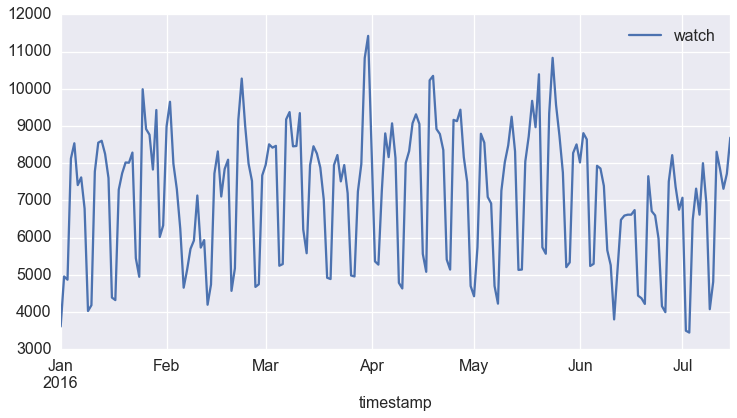

In [433]:
data["repo_name"].resample('D').apply({'watch':'count'}).plot();

### Ratings por dia da semana

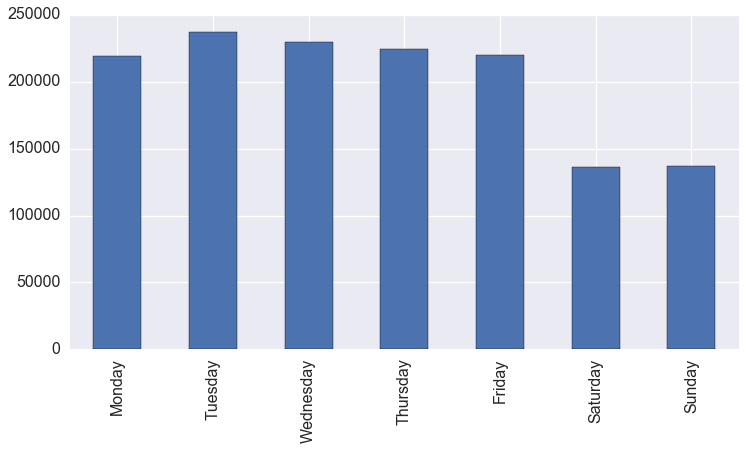

In [434]:
data["actor_login"].groupby(data.index.weekday_name).count() \
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday",
              "Saturday", "Sunday"]) \
    .plot(kind="bar");

### Distribuição de ratings por usuário

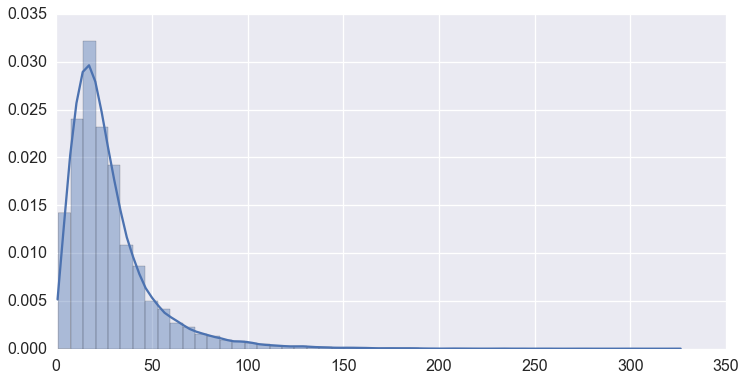

In [435]:
sns.distplot(data.groupby("actor_login").size());

# <a name="recomendacao"/>Recomendação </a>

# <a name="popularidade"/>Baseline: Popularidade </a>

### Top 10 repositórios mais populares

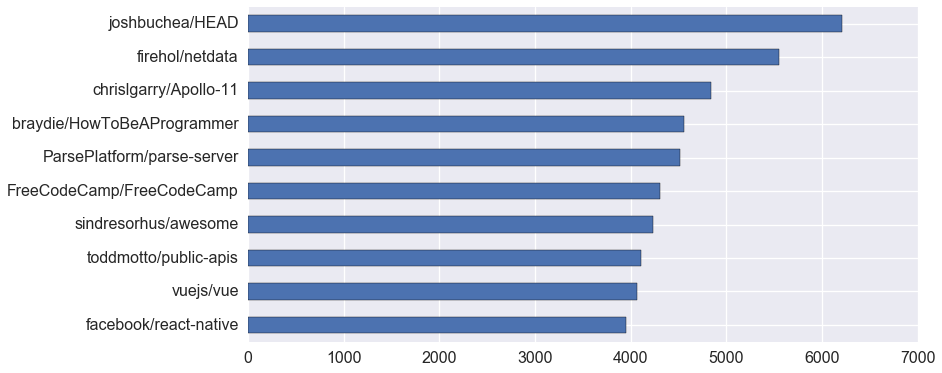

In [436]:
top_repos = data["repo_name"].value_counts().head(10)
top_repos[::-1].plot(kind="barh");

# <a name="filtr-col"/>Filtragem colaborativa</a>

## Matriz de preferências

<center><img src="files/user_item_matrix.png" style="height: 600px;" /></center>

In [437]:
ratings = data.pivot_table(index="actor_login", columns="repo_name", 
    aggfunc="size")

In [438]:
ratings.head()  

repo_name,0x5e/wechat-deleted-friends,0xAX/linux-insides,1000ch/grd,10up/flexibility,81813780/AVLoadingIndicatorView,AFNetworking/AFNetworking,Alamofire/Alamofire,AllThingsSmitty/css-protips,AngularClass/angular2-webpack-starter,AngularClass/awesome-angular2,...,zeithq/micro,zenorocha/clipboard.js,zhengwenming/WMPlayer,ziadoz/awesome-php,zingchart/zingtouch,zonination/investing,zquestz/s,zurb/foundation-sites,zxing/zxing,zyedidia/micro
actor_login,,,,,,,,,,,,,,,,,,,,,
0000-bigtree,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000fan000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
007lva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00Green27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00o0o,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [439]:
dense_ratings = ratings.fillna(0)
dense_ratings.head()

repo_name,0x5e/wechat-deleted-friends,0xAX/linux-insides,1000ch/grd,10up/flexibility,81813780/AVLoadingIndicatorView,AFNetworking/AFNetworking,Alamofire/Alamofire,AllThingsSmitty/css-protips,AngularClass/angular2-webpack-starter,AngularClass/awesome-angular2,...,zeithq/micro,zenorocha/clipboard.js,zhengwenming/WMPlayer,ziadoz/awesome-php,zingchart/zingtouch,zonination/investing,zquestz/s,zurb/foundation-sites,zxing/zxing,zyedidia/micro
actor_login,,,,,,,,,,,,,,,,,,,,,
0000-bigtree,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000fan000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
007lva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Green27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00o0o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a name="itens-similares"/>Recomendação para item</a>

## <a name="item-similarity"/>Itens Similares </a>


<center><img src="files/item_vector.png" style="height: 600px;"/></center>

<center><img src="files/cosine_similarity_agg.png" style="height: 500px;"/></center>

## Matriz de similaridade dos itens

<center><img src="files/item_similarity_matrix.png" style="height: 500px;"/></center>

In [440]:
from sklearn.metrics.pairwise import pairwise_distances

In [480]:
A = np.matrix([1, 0, 0])
B = np.matrix([1, 0, 0])
pairwise_distances(X=A, Y=B, metric='cosine')

array([[ 0.]])

In [443]:
item_similarity = 1 - pairwise_distances(X=dense_ratings.T,
                                         metric='cosine')

In [444]:
item_similarity

array([[ 1.        ,  0.02905673,  0.02914921, ...,  0.02331462,
         0.05263604,  0.01424128],
       [ 0.02905673,  1.        ,  0.03449859, ...,  0.01721216,
         0.01330494,  0.06209662],
       [ 0.02914921,  0.03449859,  1.        , ...,  0.03237552,
         0.0085804 ,  0.09166154],
       ..., 
       [ 0.02331462,  0.01721216,  0.03237552, ...,  1.        ,
         0.02033458,  0.01476304],
       [ 0.05263604,  0.01330494,  0.0085804 , ...,  0.02033458,
         1.        ,  0.00745259],
       [ 0.01424128,  0.06209662,  0.09166154, ...,  0.01476304,
         0.00745259,  1.        ]])

In [445]:
def top_similarity(item, n=10):
    return pd.DataFrame(
        index=dense_ratings.columns,
        data=item_similarity[dense_ratings.columns.get_loc(item)],
        columns=["similarity"]
    ).sort_values("similarity", ascending=False).head(n=n)

In [449]:
repo = top_repos.index[0]
top_similarity(repo)

,similarity
repo_name,
joshbuchea/HEAD,1.000000
git-tips/tips,0.344195
toddmotto/public-apis,0.329226
loverajoel/jstips,0.308907
juliangarnier/anime,0.306304
DrkSephy/es6-cheatsheet,0.300288
Nickersoft/push.js,0.298986
NamPNQ/You-Dont-Need-Javascript,0.294398
jgthms/bulma,0.293174


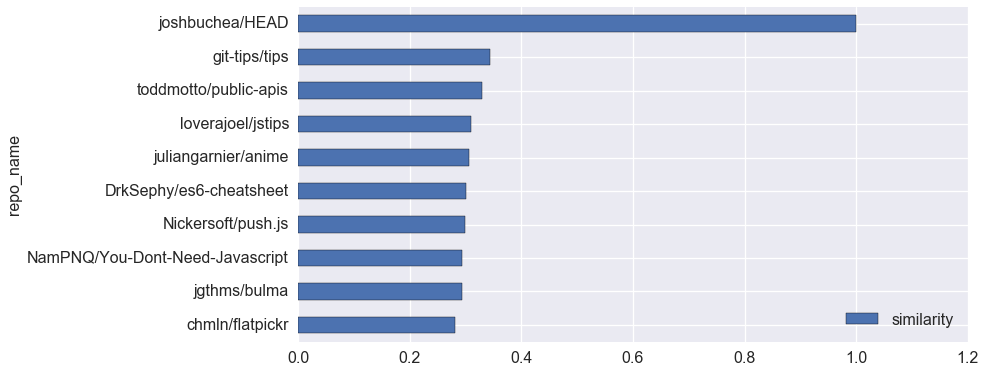

In [450]:
top_similarity(repo)[::-1].plot(kind="barh"); 

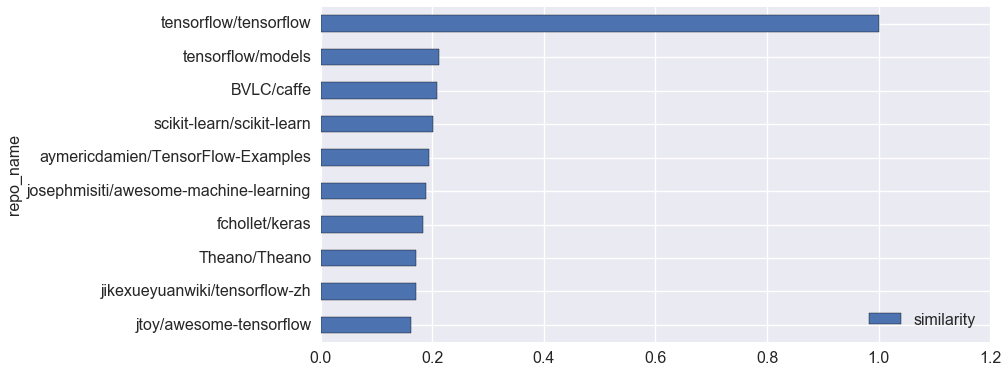

In [451]:
top_similarity("tensorflow/tensorflow")[::-1].plot(kind="barh");

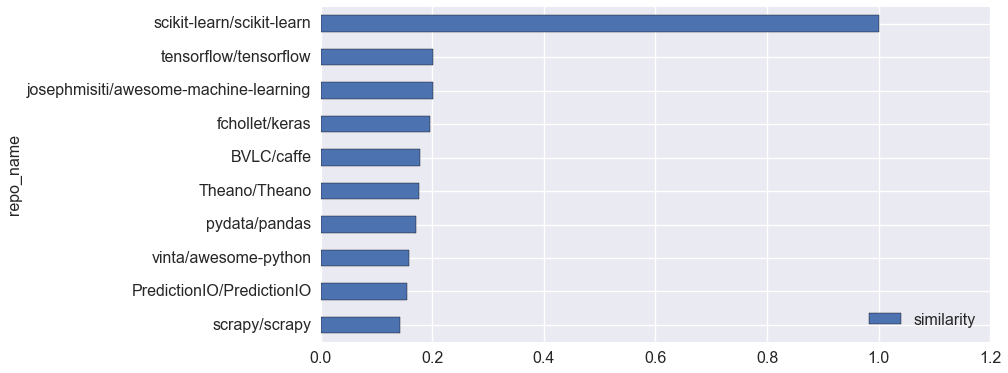

In [452]:
top_similarity("scikit-learn/scikit-learn")[::-1].plot(kind="barh");

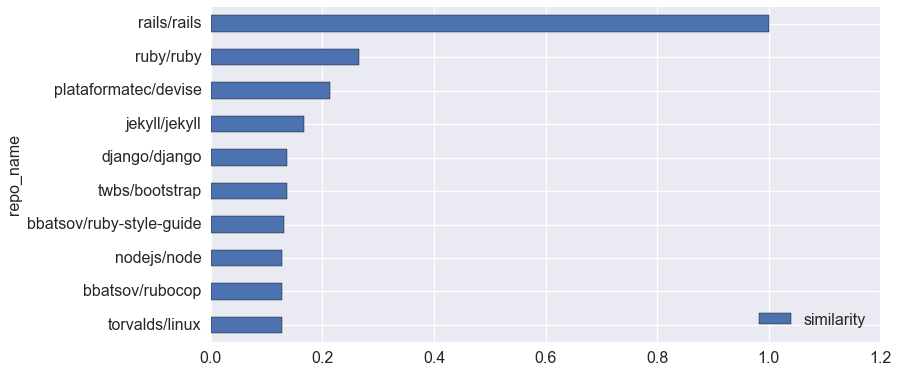

In [453]:
top_similarity("rails/rails")[::-1].plot(kind="barh");

## <a name="rec-user"/>Recomendação para usuário </a>

## <a name="rec-user-user"/>Baseada em usuários</a>

<center><img src="files/cf-user-based-knn.png" style="height: 500px;"/></center>

In [454]:
def get_history(user):
    df = ratings.T[user]
    return list(df[df.notnull()].index.values)

In [455]:
get_history("jbochi")

[u'caesar0301/awesome-public-datasets',
 u'cemoody/lda2vec',
 u'kubernetes/kubernetes']

In [456]:
def get_user_ratings(user):
    return dense_ratings.T[user]

In [457]:
get_user_ratings("jbochi").head()

repo_name
0x5e/wechat-deleted-friends        0.0
0xAX/linux-insides                 0.0
1000ch/grd                         0.0
10up/flexibility                   0.0
81813780/AVLoadingIndicatorView    0.0
Name: jbochi, dtype: float64

In [458]:
def remove_already_seen(recommended, seen):
    return recommended * (1 - seen)

In [459]:
remove_already_seen(np.array([1, 1, 1]), np.array([0, 1, 0]))    

array([1, 0, 1])

In [460]:
def top_k_neighbours(user, k=10):
    user_similarity = 1 - pairwise_distances(
        X=dense_ratings,
        Y=dense_ratings.T[user].reshape(1, -1),
        metric='cosine')
    return pd.DataFrame(
        index=dense_ratings.index,
        data=user_similarity,
        columns=["similarity"]
    ).sort_values("similarity", ascending=False).drop(user).head(n=k) 

In [461]:
top_k_neighbours("jbochi")

,similarity
actor_login,
sleyzerzon,0.577350
dnvriend,0.577350
bennokr,0.577350
rleonid,0.577350
jt6211,0.516398
shatu,0.471405
testphys,0.436436
gpcr,0.408248
tbrown1979,0.408248


In [462]:
map(get_history, _.index[:6])

[[u'caesar0301/awesome-public-datasets'],
 [u'caesar0301/awesome-public-datasets'],
 [u'caesar0301/awesome-public-datasets'],
 [u'caesar0301/awesome-public-datasets'],
 [u'RPISEC/Malware',
  u'avelino/awesome-go',
  u'caesar0301/awesome-public-datasets',
  u'cemoody/lda2vec',
  u'jlund/streisand'],
 [u'baidu-research/warp-ctc',
  u'bayandin/awesome-awesomeness',
  u'caesar0301/awesome-public-datasets',
  u'cemoody/lda2vec',
  u'josephmisiti/awesome-machine-learning',
  u'sindresorhus/awesome']]

In [463]:
def get_knn_user_recommendations(user, k=10, n=10):
    neighbours = top_k_neighbours(user, k)
    neighbours_ratings = dense_ratings.T[neighbours.index].T
    
    predicted_ratings = \
        np.dot(neighbours.T, neighbours_ratings).ravel() / \
        np.sum(neighbours).ravel()
        
    user_ratings = get_user_ratings(user) 
    not_seen = remove_already_seen(predicted_ratings, user_ratings.values)
    user_recommendations = pd.Series(
        index=ratings.columns,
        data=not_seen,
        name="rating")
    return user_recommendations.sort_values(ascending=False).head(n)

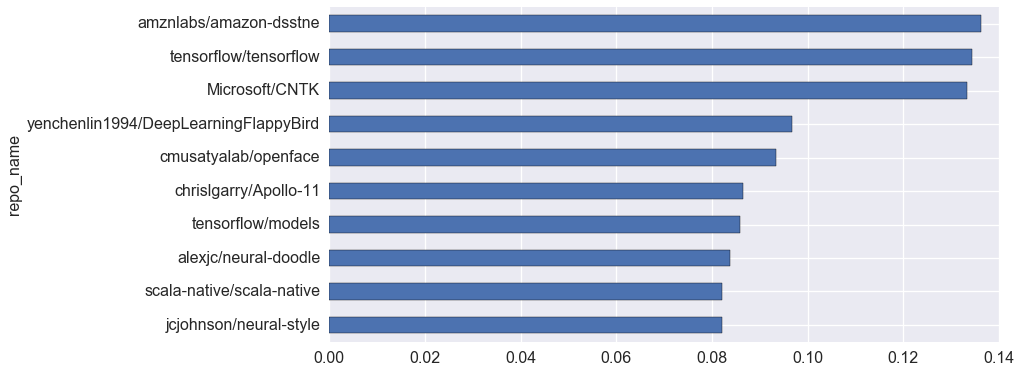

In [481]:
get_knn_user_recommendations("jbochi",k=20)[::-1].plot(kind="barh");

## <a name="rec-user2"/>Recomendação para usuário </a>

## <a name="rec-user-item"/>Baseada em itens</a>

<center><img src="files/cf-item-based.png" style="height: 500px;"/></center>

In [468]:
def get_user_item_recommendations(user, n=10):
    user_ratings = get_user_ratings(user)
    predicted_ratings = \
        np.dot(user_ratings, item_similarity.T) / user_ratings.sum()
    not_seen = remove_already_seen(predicted_ratings, 
                                   user_ratings.values)
    user_recommendations = pd.Series(
        index=ratings.columns,
        data=not_seen,
        name="rating")
    return user_recommendations.sort_values(ascending=False).head(n)

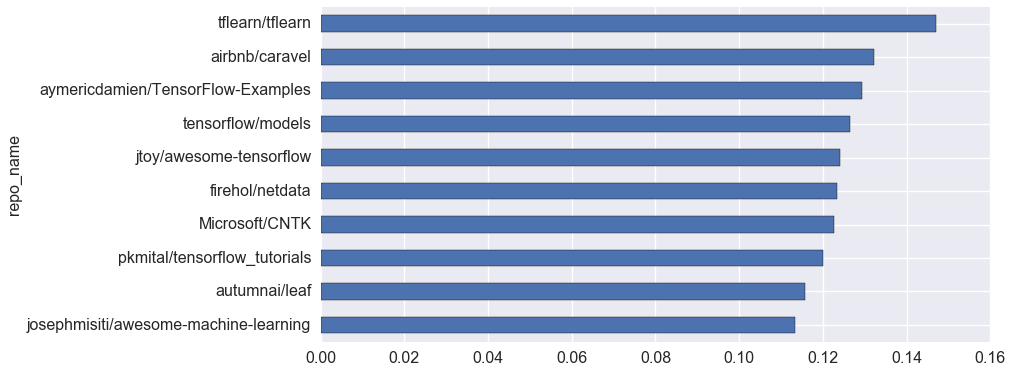

In [469]:
get_user_item_recommendations("jbochi")[::-1].plot(kind="barh");

## <a name="rec-user-svd"/>Recomendação para Usuário com SVD </a>

<center><img src="files/rec-svd.png" style="height: 400px;"/></center>

In [470]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import numpy as np

u, s, vt = svds(dense_ratings, k=20)

In [471]:
u.shape, s.shape, vt.shape

((50365, 20), (20,), (20, 1454))

In [472]:
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
ratings_pred = pd.DataFrame(
    data=X_pred, index=ratings.index, columns=ratings.columns)

In [473]:
def get_svd_recommendations(user, n=10):
    predicted_ratings = ratings_pred.T[user]
    user_ratings = get_user_ratings(user) 
    not_seen = remove_already_seen(predicted_ratings, 
                                   user_ratings.values)
    user_recommendations = pd.Series(
        index=ratings.columns,
        data=not_seen,
        name="rating")
    return user_recommendations.sort_values(ascending=False).head(n)

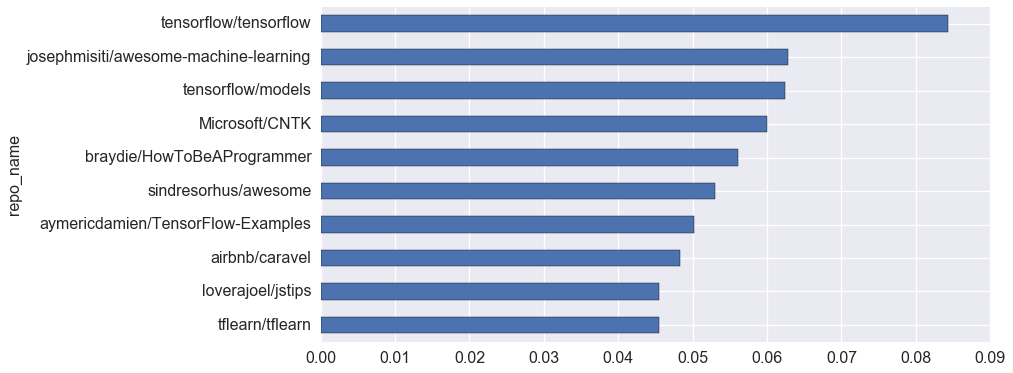

In [474]:
get_svd_recommendations("jbochi")[::-1].plot(kind="barh");

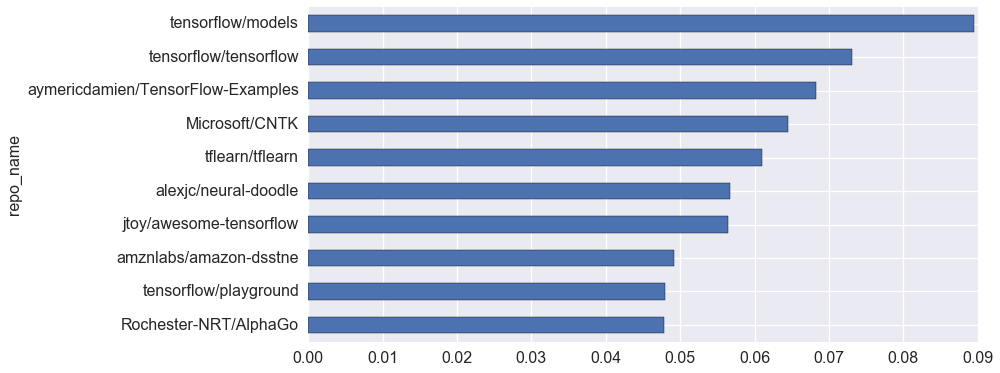

In [475]:
get_svd_recommendations("perone")[::-1].plot(kind="barh");

In [476]:
def show_all_recs(user):
    plt.figure(figsize=(12,6.5))
    plt.subplot(3,1,1); 
    get_knn_user_recommendations(user, n=3)[::-1].plot(kind="barh", title="knn").set_ylabel("");
    plt.subplot(3,1,2); 
    get_user_item_recommendations(user, n=3)[::-1].plot(kind="barh", title="user-item").set_ylabel("");
    plt.subplot(3,1,3); 
    get_svd_recommendations(user, n=3)[::-1].plot(kind="barh", title="svd").set_ylabel("");
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.show()

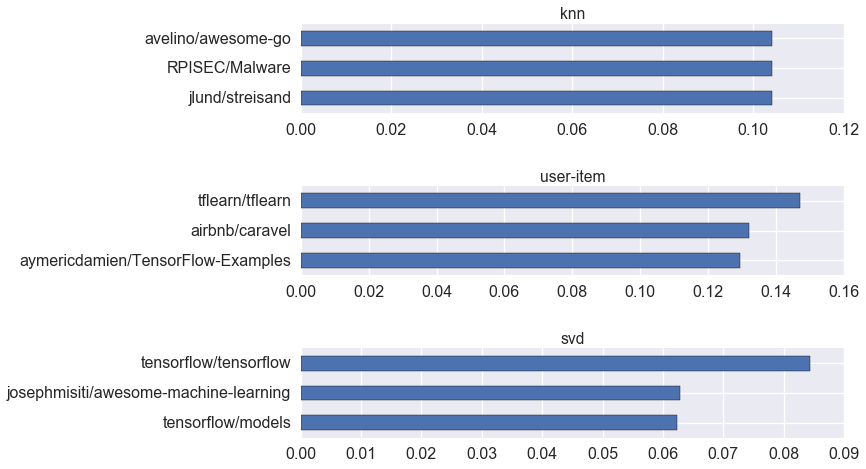

In [477]:
show_all_recs("jbochi")

# Próximos Passos
- Recomendação baseada em Conteúdo
- Combinação dos algoritmos
- Avaliação da recomendação
- Processamento distribuído
- Outros algoritmos ...

# <div style="text-align: center;">Obrigado ! </div>
<br>
## Juarez da Silva Bochi
#### jbochi@gmail.com
<br>
## Júlia Kikuye Kambara da Silva
#### julia.kikuye@gmail.com